# Irony detector
The goal of this project is to create system that detects if the given sentence is ironic or not.  
It will be achieved by correctly parsing the training data and learning the underlying dependencies.

In [2]:
import os
import numpy as np
import codecs
import csv   
from scipy.spatial.distance import euclidean
from nltk.tokenize import RegexpTokenizer
import nltk
from pprint import pprint
import matplotlib.pyplot as plt

In [3]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.models import model_from_json
from keras.regularizers import L1L2
from keras import regularizers

D:\Anaconda\Anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Dataset
The dataset, that will be used in the training process, consists of downloaded reddit comments that are either ironic or not. The data was manually labeled by humans.  
Link: https://github.com/bwallace/ACL-2014-irony/blob/master/irony-labeled.csv

In [4]:
path_to_irony_data = "./"
irony_data_file = "irony-labeled.csv"

In [5]:
final_path_irony = os.path.join(path_to_irony_data, irony_data_file)
irony_dict = {"ironic": [],
             "non_ironic": []}
with open(final_path_irony, newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    tokenizer = RegexpTokenizer(r'\w+')
    for row in reader:
#         row[0] = tokenizer.tokenize(row[0])
#         row[0] = [word.lower() for word in row[0]]
        if row[1] == "1":
            irony_dict["ironic"].append(row[0])
        elif row[1] == "-1":
            irony_dict["non_ironic"].append(row[0])

In [6]:
pprint(irony_dict["ironic"][2])
pprint(irony_dict["non_ironic"][2])

("Insane like a fox.  Ted Cruz is actually very very intelligent.  It's his "
 "constituents that are insane.  He's just playing the part.")
('We are truly following the patterns of how the mandarins took over empires, '
 'not because of the sword, but because control of the endless paper, and '
 "regulations, that do more to stagnate most people's lives, then to do "
 'anything productive. \n'
 '\n'
 "But then because they don't see what else they can do, they write up even "
 'more laws and regulations, that either do nothing, or hinder more freedom '
 'and production.')


### Notes about dataset
As it is shown below the dataset is quite small which will for sure affect the final outlook of the system.  
Moreover there are more non-ironic comments than ironic ones.

In [7]:
ironic_no = len(irony_dict["ironic"])
non_ironic_no = len(irony_dict["non_ironic"])
print("Number of ironic tweets in dataset: " + str(ironic_no))
print("Number of non-ironic tweets in dataset: " + str(non_ironic_no))

Number of ironic tweets in dataset: 537
Number of non-ironic tweets in dataset: 1412


## Word embedding
In order to feed our data to neural network it must be transformed to a valid vector space.  
To achieve that goal we will use pre-trained glove word embedding. It was trained on a tweeter data sentences which consists very similar language to one taken from reddit.

In [8]:
path_to_data = "./glove.twitter.27B"
word_embeddings_file = "glove.twitter.27B.100d.txt"

In [9]:
embeddings_index = {}
final_path = os.path.join(path_to_data, word_embeddings_file)
file = codecs.open(final_path, "r", "utf-8")
for line in file:
    values = line.split()
    if len(values) > 1:
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        if len(coefs) == 100:
            embeddings_index[word] = coefs
file.close()

print('Found %s word vectors.' % len(embeddings_index))
pprint(embeddings_index["trump"])

Found 1193513 word vectors.
array([-0.24645  ,  0.45248  ,  0.8372   ,  0.1301   , -0.10773  ,
       -0.23649  , -0.022622 , -0.19291  ,  0.0089398, -0.42653  ,
        0.46929  , -0.2226   , -1.5809   , -0.50369  ,  0.302    ,
       -0.032982 , -0.82088  , -0.30826  ,  0.32375  ,  0.079145 ,
        0.45206  , -0.60606  , -0.021866 ,  0.33313  , -0.023317 ,
        0.44279  ,  0.47152  , -0.037821 , -0.072843 , -0.72901  ,
        0.65716  ,  0.19021  , -0.34567  , -0.71308  ,  0.034026 ,
        0.30534  , -0.21855  ,  0.024003 , -0.14556  , -0.68436  ,
        0.93626  ,  0.12909  , -0.17345  , -0.68616  ,  0.011613 ,
        0.32246  , -0.48218  , -0.12962  , -0.12519  ,  0.36592  ,
       -0.058803 , -0.99927  , -0.39455  ,  0.29715  , -0.44197  ,
        0.16283  ,  0.17432  , -0.74203  , -0.41865  ,  0.21203  ,
        0.18244  , -0.020944 ,  0.051607 , -0.17384  ,  0.16151  ,
       -0.39944  ,  0.52242  ,  0.55355  , -0.70574  ,  0.1701   ,
       -0.22219  , -0.61542  , -0.

### Embedding note
Although currently used word embedding has 27 bilion avaiable words in it, there is always an option that one specific word won't be avaiable. In that case the embedding will return vector that is average of all word vectors.

In [10]:
center_vec = np.zeros(100)
for key in embeddings_index:
    center_vec += embeddings_index[key]
    
center_vec /= len(embeddings_index)
pprint(center_vec)

array([-1.55613814e-01, -3.93494080e-03, -3.25424393e-02, -6.28340323e-02,
       -4.78166663e-03, -1.84618781e-01, -4.94442110e-02, -1.80519962e-01,
       -3.35795790e-02, -1.94204960e-01, -6.56427410e-02,  3.70128192e-02,
        6.60843968e-01, -7.80551770e-03, -1.94730733e-04,  9.07417013e-02,
        8.08833436e-02,  7.30225436e-02,  2.30259100e-01,  9.59613673e-02,
        1.10937550e-01,  4.32485998e-02,  6.52083750e-02, -6.03178325e-02,
       -2.05841881e-01,  7.50283779e-01,  1.29858423e-01,  1.11143313e-01,
       -3.51633677e-01,  2.48396838e-02,  2.55200058e-01,  1.77183579e-01,
        4.26655982e-01, -2.19324079e-01, -4.53463816e-01, -1.41411191e-01,
       -8.41410392e-03,  1.01714924e-02,  6.76633824e-02,  1.28282624e-01,
        6.85160399e-01, -1.77480437e-02,  1.28946731e-01, -7.42800473e-02,
       -3.58293143e-01,  9.97250462e-02, -5.09561403e-02,  5.47891582e-03,
        6.24780618e-02,  2.89103434e-01,  3.06918598e-01,  9.53836828e-02,
       -8.97601022e-02, -

In [11]:
def get_vec(word):
    if word in embeddings_index:
        return embeddings_index[word]
    return center_vec

## Data division
In order to correctly train neural network and corectly test it later one must split dataset into training data and test data. The training data is then transformed into training and validation data.

In [12]:
Y=[]
for i in range(len(irony_dict["ironic"])):
    Y.append(1)

for i in range(len(irony_dict["non_ironic"])):
    Y.append(0)
    
X = []
for sentence in irony_dict["ironic"]:
    X.append(sentence)

for sentence in irony_dict["non_ironic"]:
    X.append(sentence)

In [13]:
for i, sentence in enumerate(X):
    if i < 5:
        label = "ironic" if Y[i] == 1 else "non-ironic"
        print("Sentence:\n" + sentence +"\nLabel: " + label+"\n\n")

Sentence:
Democrats don't know how to manage money?   Shocking!
Label: ironic


Sentence:
It's not like automation has eliminated the need for any manual labor since the 40 hour work week was established or anything.
Label: ironic


Sentence:
Insane like a fox.  Ted Cruz is actually very very intelligent.  It's his constituents that are insane.  He's just playing the part.
Label: ironic


Sentence:
If Jesus destroyed satan for our freedom, why is there still evil, Tom, huh?  Huh?  Why Tom?
Label: ironic


Sentence:
Because the Reddit Liberal Brigade™ would downvote it to oblivion within minutes?  Does that sound about right?
Label: ironic




In [14]:
percent_test = 0.1
sidx = np.random.permutation(len(X))
n_train = int(np.round(len(X) * (percent_test)))
percent_validation = 0.1
n_validation = int(np.round(len(X) * (percent_validation)))
X_train = [X[s] for s in sidx[n_train:]]
Y_train = [Y[s] for s in sidx[n_train:]]
X_validation = [s for s in X_train[:n_validation]]
Y_validation = [s for s in Y_train[:n_validation]]
X_train = [s for s in X_train[n_validation:]]
Y_train = [s for s in Y_train[n_validation:]]
X_test = [X[s] for s in sidx[:n_train]]
Y_test = [Y[s] for s in sidx[:n_train]]
print("Number of ironic tweets in train data: " + str(len([sen for i, sen in enumerate(X_train) if Y_train[i] == 1])))
print("Number of non-ironic tweets in train data: " + str(len([sen for i, sen in enumerate(X_train) if Y_train[i] == 0])))
print("Number of ironic tweets in test data: " + str(len([sen for i, sen in enumerate(X_test) if Y_test[i] == 1])))
print("Number of non-ironic tweets in test data: " + str(len([sen for i, sen in enumerate(X_test) if Y_test[i] == 0])))
print("Number of ironic tweets in validation data: " + str(len([sen for i, sen in enumerate(X_validation) if Y_validation[i] == 1])))
print("Number of non-ironic tweets in validation data: " + str(len([sen for i, sen in enumerate(X_validation) if Y_validation[i] == 0])))

Number of ironic tweets in train data: 426
Number of non-ironic tweets in train data: 1133
Number of ironic tweets in test data: 55
Number of non-ironic tweets in test data: 140
Number of ironic tweets in validation data: 56
Number of non-ironic tweets in validation data: 139


In [15]:
def print_sample_results(model):
    # print sentences in which model labels correctly and incorrectly
    label = 1
    correct_ironic = []
    incorrect_ironic = []
    correct_non_ironic = []
    incorrect_non_ironic = []
    for i, sen in enumerate(X_test):
        if len(correct_ironic) == 5 and len(incorrect_ironic) == 5 and len(correct_non_ironic) == 5 and len(incorrect_non_ironic) == 5:
            break
        label = Y_test[i]
        my_enc_docs = t.texts_to_sequences([sen])
        my_padded_docs = pad_sequences(my_enc_docs, maxlen=max_length, padding='post')
        loss, accuracy = model.evaluate(my_padded_docs, [label], verbose=0)
        if label == 1:
            if accuracy == 1 and len(correct_ironic) < 5:
                correct_ironic.append(sen)
            elif accuracy == 0 and len(incorrect_ironic) < 5:
                incorrect_ironic.append(sen)
        else:
            if accuracy == 1 and len(correct_non_ironic) < 5:
                correct_non_ironic.append(sen)
            elif accuracy == 0 and len(incorrect_non_ironic) < 5:
                incorrect_non_ironic.append(sen)

    print("\n\nCorrectly choosen ironic sentences: ")
    pprint(correct_ironic)
    print("\n\nIncorrectly choosen ironic sentences: ")
    pprint(incorrect_ironic)
    print("\n\nCorrectly choosen non-ironic sentences: ")
    pprint(correct_non_ironic)
    print("\n\nIncorrectly choosen non-ironic sentences: ")
    pprint(incorrect_non_ironic)

In [16]:
def save_model(model, file_path):
    # serialize model to JSON
    model_json = model.to_json()
    with open(file_path+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(file_path+".h5")
    print("Saved model to disk")

In [41]:
def load_model(file_path, compile_model=True):
    # load json and create model
    json_file = open(file_path+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(file_path+".h5")
    print("Loaded model from disk")
    if compile_model:
        # compile the model
        loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return loaded_model

In [18]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['acc'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
#                        , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history

In [19]:
def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

## Tokenizing
To feed our data to neural network we must tokenize it at first and then chage it to index form. Fortunately Keras library has mechanisms for that

In [33]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X)
vocab_size = len(t.word_index) + 1
print("Vocabulary size = " + str(vocab_size))
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train)
# pad documents to a max length of 4 words
max_length = 30
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

encoded_docs_test =  t.texts_to_sequences(X_test)
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

encoded_docs_validation =  t.texts_to_sequences(X_validation)
padded_docs_validation = pad_sequences(encoded_docs_validation, maxlen=max_length, padding='post')

Vocabulary size = 9753


In [21]:
print("Encoded docs:")
for i, doc in enumerate(encoded_docs):
    if i < 5:
        pprint(doc)
print("Padded docs:")       
for i, doc in enumerate(padded_docs):
    if i < 5:
        pprint(doc)

Encoded docs:
[760,
 1021,
 4695,
 4,
 337,
 1,
 4696,
 3170,
 1,
 153,
 105,
 92,
 1917,
 1,
 364,
 327,
 1932,
 1,
 187,
 4697,
 40,
 12,
 313,
 5,
 365,
 43,
 3171,
 41,
 11,
 1277,
 433,
 140,
 529,
 1,
 4698,
 326]
[4,
 68,
 1,
 153,
 813,
 146,
 88,
 1,
 461,
 141,
 9,
 374,
 5,
 297,
 123,
 73,
 31,
 90,
 305,
 3241,
 2442,
 961,
 71,
 67,
 1178,
 245,
 159]
[918,
 2682,
 2,
 112,
 1,
 8197,
 5,
 8198,
 946,
 68,
 52,
 7,
 317,
 92,
 10,
 28,
 18,
 68,
 545,
 5,
 4056,
 844,
 8,
 50,
 829,
 10,
 188,
 25,
 52,
 5,
 1,
 8199,
 1711,
 9,
 2224,
 328]
[8,
 433,
 7,
 334,
 4198,
 71,
 8,
 23,
 9,
 1,
 2486,
 42,
 1,
 81,
 4,
 3,
 253,
 8184,
 4,
 8,
 444,
 60,
 1474,
 202,
 1679,
 92,
 8185,
 58,
 50,
 433,
 33,
 970,
 216,
 8186,
 529,
 74,
 1833,
 8187,
 75,
 250,
 973,
 70,
 3,
 8188,
 36,
 7,
 335,
 34,
 332,
 5,
 204,
 1119,
 4,
 35,
 2801,
 10,
 423,
 4434,
 1019,
 166,
 34,
 10,
 9,
 3163,
 1014,
 8189,
 7,
 1,
 632,
 23,
 3,
 8190,
 8191,
 806,
 4,
 27,
 334,
 8192,
 87,
 35

## Embedding Layer
The first layer of our neural network is an already trained embedding layer. Now we must transform it to matrix and disable learning on it 

In [22]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = get_vec(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
NB_START_EPOCHS=50

## First simple LSTM neural network model
First we will test simple LSTM neural network without any regularizers or dropouts to observe how will it behave and probably overfit

Train on 1559 samples, validate on 195 samples
Epoch 1/50
1559/1559 [==============================] - 5s 3ms/step - loss: 0.5855 - acc: 0.7229 - val_loss: 0.5803 - val_acc: 0.7128
Epoch 2/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.5641 - acc: 0.7267 - val_loss: 0.5661 - val_acc: 0.7128
Epoch 3/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.5510 - acc: 0.7274 - val_loss: 0.5678 - val_acc: 0.7128
Epoch 4/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.5390 - acc: 0.7332 - val_loss: 0.5693 - val_acc: 0.7231
Epoch 5/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.5226 - acc: 0.7389 - val_loss: 0.5738 - val_acc: 0.6667
Epoch 6/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.5009 - acc: 0.7537 - val_loss: 0.5600 - val_acc: 0.7179
Epoch 7/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.4741 - acc: 0.7678 - val_loss: 0.5810 - val_acc: 0.7128
Epoch 8/50
1559

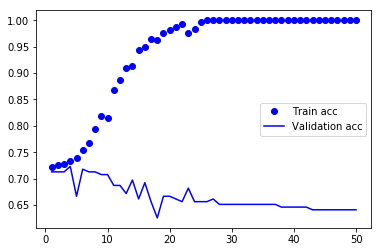

Saved model to disk


In [24]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

history = deep_model(model, padded_docs, Y_train, padded_docs_validation, Y_validation)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, Y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
eval_metric(history, 'acc')
save_model(model, "models/simple1")

In [25]:
my_sen = ["My totaly unironic sentence",
          "I love driving home alone at night through dangerous neighbourhood",
         "Democrats don't know how to manage money? Shocking!"]
my_label = [0, 1, 1]
my_enc_docs = t.texts_to_sequences(my_sen)
my_padded_docs = pad_sequences(my_enc_docs, maxlen=max_length, padding='post')
# evaluate the model
loss, accuracy = model.evaluate(my_padded_docs, my_label, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 66.666669


## Second more complicated model
The second model will be more complicated. We are adding additional 3 LSTM layers that will be bidirectional. This will presumably allow us to learn more distinct features of irony. In this model we won't use neighter regularizers nor dropouts also to observe overfitting.

Train on 1559 samples, validate on 195 samples
Epoch 1/50
1559/1559 [==============================] - 32s 21ms/step - loss: 0.5787 - acc: 0.7255 - val_loss: 0.5597 - val_acc: 0.7128
Epoch 2/50
1559/1559 [==============================] - 25s 16ms/step - loss: 0.5706 - acc: 0.7300 - val_loss: 0.5861 - val_acc: 0.7179
Epoch 3/50
1559/1559 [==============================] - 25s 16ms/step - loss: 0.5493 - acc: 0.7306 - val_loss: 0.5518 - val_acc: 0.7231
Epoch 4/50
1559/1559 [==============================] - 25s 16ms/step - loss: 0.5386 - acc: 0.7441 - val_loss: 0.5534 - val_acc: 0.7231
Epoch 5/50
1559/1559 [==============================] - 26s 17ms/step - loss: 0.5110 - acc: 0.7543 - val_loss: 0.5568 - val_acc: 0.7077
Epoch 6/50
1559/1559 [==============================] - 25s 16ms/step - loss: 0.4670 - acc: 0.7742 - val_loss: 0.5638 - val_acc: 0.7026
Epoch 7/50
1559/1559 [==============================] - 25s 16ms/step - loss: 0.4297 - acc: 0.8056 - val_loss: 0.6905 - val_acc: 0.6103
E

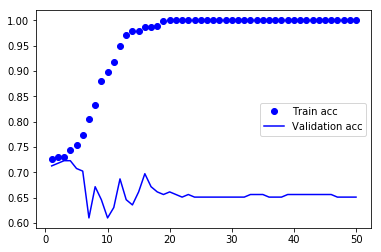

Saved model to disk


In [28]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

history = deep_model(model, padded_docs, Y_train, padded_docs_validation, Y_validation)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, Y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
eval_metric(history, 'acc')
save_model(model, "models/complex1")

In [30]:
my_sen = ["My totaly unironic sentence",
          "I love driving home alone at night through dangerous neighbourhood",
         "Democrats don't know how to manage money? Shocking!"]
my_label = [0, 1, 1]
my_enc_docs = t.texts_to_sequences(my_sen)
my_padded_docs = pad_sequences(my_enc_docs, maxlen=max_length, padding='post')
# evaluate the model
loss, accuracy = model.evaluate(my_padded_docs, my_label, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 66.666669


## Third simple model with regularizers
Now we want to test our simple model with regularizers to see if they will help with overfitting

Train on 1559 samples, validate on 195 samples
Epoch 1/50
1559/1559 [==============================] - 7s 4ms/step - loss: 15.5910 - acc: 0.7101 - val_loss: 8.0267 - val_acc: 0.7128
Epoch 2/50
1559/1559 [==============================] - 3s 2ms/step - loss: 4.0147 - acc: 0.7267 - val_loss: 1.2770 - val_acc: 0.7128
Epoch 3/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.8603 - acc: 0.7267 - val_loss: 0.7413 - val_acc: 0.7128
Epoch 4/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.7270 - acc: 0.7267 - val_loss: 0.7243 - val_acc: 0.7128
Epoch 5/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.7176 - acc: 0.7267 - val_loss: 0.7166 - val_acc: 0.7128
Epoch 6/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.7136 - acc: 0.7267 - val_loss: 0.7120 - val_acc: 0.7128
Epoch 7/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.7098 - acc: 0.7267 - val_loss: 0.7103 - val_acc: 0.7128
Epoch 8/50
155

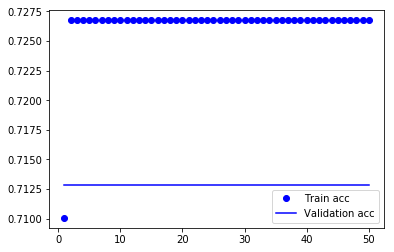

Saved model to disk


In [34]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100, kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))

history = deep_model(model, padded_docs, Y_train, padded_docs_validation, Y_validation)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, Y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
eval_metric(history, 'acc')
save_model(model, "models/simple2")

## Fourth model with dropout
After concluding that regularizers caused overfitting problem to disapear we will add dropout layer to see if it will make our network more general in use.

Train on 1559 samples, validate on 195 samples
Epoch 1/50
1559/1559 [==============================] - 7s 4ms/step - loss: 15.5248 - acc: 0.7248 - val_loss: 7.9952 - val_acc: 0.7128- ETA: 0s - loss: 16.5712 - acc: 0.72 - ETA: 0s - loss: 16.4118 -
Epoch 2/50
1559/1559 [==============================] - 3s 2ms/step - loss: 3.9823 - acc: 0.7267 - val_loss: 1.2632 - val_acc: 0.7128
Epoch 3/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.8575 - acc: 0.7267 - val_loss: 0.7376 - val_acc: 0.7128
Epoch 4/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.7239 - acc: 0.7267 - val_loss: 0.7190 - val_acc: 0.7128
Epoch 5/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.7162 - acc: 0.7267 - val_loss: 0.7204 - val_acc: 0.7128
Epoch 6/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.7155 - acc: 0.7267 - val_loss: 0.7161 - val_acc: 0.7128
Epoch 7/50
1559/1559 [==============================] - 3s 2ms/step - loss: 0.7157 

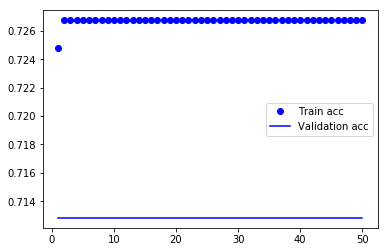

Saved model to disk


In [35]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100, kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2, input_shape=(100,)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))

history = deep_model(model, padded_docs, Y_train, padded_docs_validation, Y_validation)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, Y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
eval_metric(history, 'acc')
save_model(model, "models/simple3")

## Final model - complex one with regularizers
We conclude our research with a final model -> complex one but with regularizers

Train on 1559 samples, validate on 195 samples
Epoch 1/50
1559/1559 [==============================] - 36s 23ms/step - loss: 91.9261 - acc: 0.7261 - val_loss: 41.8220 - val_acc: 0.7128
Epoch 2/50
1559/1559 [==============================] - 27s 17ms/step - loss: 17.3243 - acc: 0.7267 - val_loss: 2.6809 - val_acc: 0.7128
Epoch 3/50
1559/1559 [==============================] - 25s 16ms/step - loss: 1.4945 - acc: 0.7261 - val_loss: 1.0384 - val_acc: 0.7128
Epoch 4/50
1559/1559 [==============================] - 25s 16ms/step - loss: 1.0134 - acc: 0.7280 - val_loss: 1.0241 - val_acc: 0.7128
Epoch 5/50
1559/1559 [==============================] - 26s 17ms/step - loss: 0.9744 - acc: 0.7332 - val_loss: 0.9998 - val_acc: 0.7077
Epoch 6/50
1559/1559 [==============================] - 27s 17ms/step - loss: 0.9542 - acc: 0.7447 - val_loss: 1.0082 - val_acc: 0.6974
Epoch 7/50
1559/1559 [==============================] - 27s 17ms/step - loss: 0.9183 - acc: 0.7729 - val_loss: 1.0852 - val_acc: 0.676

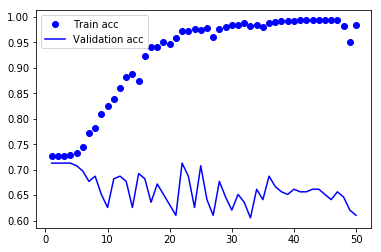

Saved model to disk


In [37]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=L1L2(l1=0.01, l2=0.01))))
model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=L1L2(l1=0.01, l2=0.01))))
model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=L1L2(l1=0.01, l2=0.01))))
model.add(Bidirectional(LSTM(100, kernel_regularizer=L1L2(l1=0.01, l2=0.01))))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))

history = deep_model(model, padded_docs, Y_train, padded_docs_validation, Y_validation)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, Y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
eval_metric(history, 'acc')
save_model(model, "models/complex2")

## Comparison between simple model and complex one
Now it is time to compare two final models

In [67]:
def count_stats(model, X_test, Y_test):        
    tp=fp=tn=fn=0
    for i, sentence in enumerate(X_test):
        sentence = [sentence]
        label = [Y_test[i]]
        my_enc_docs = t.texts_to_sequences(sentence)
        my_padded_docs = pad_sequences(my_enc_docs, maxlen=max_length, padding='post')
        # evaluate the model
        loss, accuracy = model.evaluate(my_padded_docs, label, verbose=0)
        if accuracy == 1:
            if label[0] == 1:
                tp += 1
            else:
                tn += 1
        else:
            if label[0] == 1:
                fn += 1
            else:
                fp += 1
    result_dict = {}
    result_dict["tp"] = tp
    result_dict["fp"] = fp
    result_dict["fn"] = fn
    result_dict["tn"] = tn
    
    return result_dict   

In [71]:
def count_metrics(stats):
    final_stats = {}
    #count precision
    final_stats["precision"] = stats["tp"]/(stats["tp"]+stats["fp"])
    #count recall
    final_stats["recall"] = stats["tp"]/(stats["tp"]+stats["fn"])
    #count f1
    final_stats["f1"] = 2 * (final_stats["precision"] * final_stats["recall"])/ (final_stats["precision"] + final_stats["recall"])
    return final_stats

In [69]:
model = load_model("models/complex2")
stats = count_stats(model, X_test, Y_test)
pprint(stats)
final_stats = count_metrics(stats)
pprint(final_stats)

Loaded model from disk
{'fn': 44, 'fp': 30, 'tn': 110, 'tp': 11}
{'f1': 0.22916666666666669, 'precision': 0.2682926829268293, 'recall': 0.2}


In [70]:
model = load_model("models/simple3")
stats = count_stats(model, X_test, Y_test)
pprint(stats)
final_stats = count_metrics(stats)
pprint(final_stats)

Loaded model from disk
{'fn': 55, 'fp': 0, 'tn': 140, 'tp': 0}


ZeroDivisionError: division by zero

# Conclusion
As anyone can see above the simple model wasn't able to learn complexity of the task and tried to label every sentence as non-ironic. This issue is present because majority of data was actually non-ironic and the task was to increase accuracity which model did.